In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.densenet import DenseNet201

import sys
sys.path.append('../src/')
sys.path.append('/notebook')

from models import combined_cnn
from loss import smooth_labels
from metrics import sensitivity, specificity

/Users/anthonyrentsch/anaconda3/envs/somerville-parking/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/anthonyrentsch/anaconda3/envs/somerville-parking/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/anthonyrentsch/anaconda3/envs/somerville-parking/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16"

In [2]:
# import dataframe with filenames and labels
sample = pd.read_csv('../labels/training_labels_updated_111219.csv')

In [3]:
# smooth labels
sample['full_label'] = 'aerial_' + sample['AERIAL_Driveway'].astype(int).astype(str) + \
                       '_gsv_' + sample['GSV_Driveway'].astype(int).astype(str)
sample['smooth_label'] = smooth_labels(sample['full_label'])

In [4]:
# label all unsures as 1s 
sample['temp_label'] = sample['final_label'].apply(lambda x: np.round(x))
sample['temp_label'] = sample['temp_label'].astype('int').astype('str')
sample['final_label'] =  sample['final_label'].astype('str')

In [5]:
def three_labels(aerial, gsv):
    labels = []
    for aerial_, gsv_ in zip(aerial, gsv):
        if aerial_ == 1 or gsv_ == 1:
            labels.append(1)
        elif aerial_ == 0 or gsv_ == 0:
            labels.append(0)
        elif aerial_ == 2 and gsv_ == 2:
            labels.append(2)
    return labels
        
sample['three_label'] = three_labels(sample['AERIAL_Driveway'], sample['GSV_Driveway'])
sample['three_label'] = sample['three_label'].astype(str)

In [6]:
# peak at data
sample.head()

,ADDR_NUM,FULL_STR,MBL,ADDRESS_FOR_STREET_VIEW,AERIAL_Driveway,GSV_Driveway,final_label,aerial_filename,gsv_filename,full_label,smooth_label,temp_label,three_label
0,5,DOUGLAS AVE,47-G-17,"5 DOUGLAS AVE, SOMERVILLE, MA",2.0,0.0,0.1,5_DOUGLAS_AVE_aerial.png,5_DOUGLAS_AVE.jpg,aerial_2_gsv_0,0.1,0,0
1,6,HILLSIDE CIR,38-A-47,"6 HILLSIDE CIR, SOMERVILLE, MA",1.0,2.0,0.9,6_HILLSIDE_CIR_aerial.png,6_HILLSIDE_CIR.jpg,aerial_1_gsv_2,0.9,1,1
2,8,BELMONT PL,44-A-48,"8 BELMONT PL, SOMERVILLE, MA",2.0,2.0,0.5,8_BELMONT_PL_aerial.png,8_BELMONT_PL.jpg,aerial_2_gsv_2,0.5,0,2
3,8,DRESDEN CIR,25-A-13,"8 DRESDEN CIR, SOMERVILLE, MA",2.0,2.0,0.5,8_DRESDEN_CIR_aerial.png,8_DRESDEN_CIR.jpg,aerial_2_gsv_2,0.5,0,2
4,8,HAWTHORNE ST,25-D-16,"8 HAWTHORNE ST, SOMERVILLE, MA",0.0,2.0,0.1,8_HAWTHORNE_ST_aerial.png,8_HAWTHORNE_ST.jpg,aerial_0_gsv_2,0.1,0,0


In [30]:
# parameters
aer_image_dim = (128, 128, 3) # (128, 128, 4)
aerial_dir = '../data/training/aerial_images/'
x_column = 'aerial_filename'
y_column = 'three_label' #smooth_label, temp_label
batch_size = 32
color_mode = 'rgb'

In [31]:
# split train and test
train_data, test_data = train_test_split(sample, test_size = 0.25, random_state = 100)

In [32]:
# print distribution of sets
print('train')
print(train_data[y_column].value_counts())
print('test')
print(test_data[y_column].value_counts())

train
1    291
0     57
2     18
Name: three_label, dtype: int64
test
1    92
0    20
2    10
Name: three_label, dtype: int64


In [33]:
# rebalance
rebalanced_train = pd.concat([train_data, 
                              train_data[train_data[y_column]=='0'],
                              train_data[train_data[y_column]=='0'],
                              train_data[train_data[y_column]=='0'],
                              train_data[train_data[y_column]=='2'],
                              train_data[train_data[y_column]=='2'],
                              train_data[train_data[y_column]=='2'],
                              train_data[train_data[y_column]=='2'],
                              train_data[train_data[y_column]=='2'],
                              train_data[train_data[y_column]=='2'],
                              train_data[train_data[y_column]=='2'],
                              train_data[train_data[y_column]=='2'],
                              train_data[train_data[y_column]=='2']])

In [34]:
print('rebalanced train')
print(rebalanced_train[y_column].value_counts())

rebalanced train
1    291
0    228
2    180
Name: three_label, dtype: int64


In [35]:
# data augmentation and generator
## train
#drop_channel = lambda x: x[:,:,0:3]
aerial_gen_obj = ImageDataGenerator(
    #preprocessing_function=drop_channel,
                                    horizontal_flip = True, vertical_flip = True, 
                                    width_shift_range = 0.1, height_shift_range = 0.1, 
                                    zoom_range = 0.1, rotation_range = 40)
train_generator = aerial_gen_obj.flow_from_dataframe(rebalanced_train, directory = aerial_dir,  #train_data
                                                x_col= x_column, y_col= y_column, 
                                                target_size=(aer_image_dim[0], aer_image_dim[1]), 
                                                color_mode=color_mode, class_mode='categorical', #class_mode='binary'
                                                batch_size=batch_size, 
                                                shuffle=True, seed=100)

## test
test_generator = aerial_gen_obj.flow_from_dataframe(test_data, directory = aerial_dir, 
                                                x_col= x_column, y_col= y_column, 
                                                target_size=(aer_image_dim[0], aer_image_dim[1]), 
                                                color_mode=color_mode, class_mode='categorical', #class_mode='binary'
                                                batch_size=batch_size, 
                                                shuffle=True, seed=100)

Found 699 validated image filenames belonging to 3 classes.
Found 122 validated image filenames belonging to 3 classes.


In [51]:
# define models
def satellite_cnn(image_dim = aer_image_dim, n_classes=1):
    
    sat_input_img = layers.Input(shape=image_dim, name='aerial_image_input')
    sat_cnn = layers.Conv2D(256, (3,3), activation = 'relu')(sat_input_img)
    sat_cnn = layers.MaxPooling2D((2,2))(sat_cnn)
    sat_cnn = layers.Conv2D(128, (3,3), activation = 'relu')(sat_cnn)
    sat_cnn = layers.MaxPooling2D((2,2))(sat_cnn)
    sat_cnn = layers.Conv2D(64, (3,3), activation = 'relu')(sat_cnn)
    sat_cnn = layers.MaxPooling2D((2,2))(sat_cnn)
    sat_cnn = layers.Conv2D(16, (3,3), activation = 'relu')(sat_cnn)
    sat_cnn = layers.MaxPooling2D((2,2))(sat_cnn)
    sat_cnn = layers.Conv2D(8, (3,3), activation = 'relu')(sat_cnn)
    sat_cnn = layers.MaxPooling2D((2,2))(sat_cnn)
    sat_flat = layers.Flatten()(sat_cnn)
    sat_image_embedding = layers.Dense(300, activation='relu')(sat_flat)
    
    full_embedding = layers.Dense(200, activation='relu')(sat_image_embedding)
    full_embedding = layers.Dropout(rate=0.5)(full_embedding)
    full_embedding = layers.Dense(100, activation='relu')(full_embedding)
    full_embedding = layers.Dropout(rate=0.3)(full_embedding)
    full_embedding = layers.Dense(64, activation='relu')(full_embedding)
    full_embedding = layers.Dropout(rate=0.1)(full_embedding)
    output = layers.Dense(n_classes, activation='softmax')(full_embedding)
    
    model = models.Model(inputs=sat_input_img, outputs=output)
    adam = optimizers.Adam(lr=1e-5, beta_1=0.9, beta_2=0.999, amsgrad=False)
    model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy', sensitivity, specificity])
    
    return model

def satellite_cnn_transfer(image_dim = aer_image_dim, pre_trained = None, n_classes=1):
    
    if not pre_trained:
        print('No model specified')
        return 
        
    sat_input_img = layers.Input(shape=image_dim, name='aerial_image_input')
    
    for layer in pre_trained.layers:
        layer.trainable = False
    pre_trained_embedding = pre_trained(sat_input_img)
    pre_trained_embedding = layers.Flatten()(pre_trained_embedding)
    
    full_embedding = layers.Dense(300, activation='relu')(pre_trained_embedding)
    full_embedding = layers.Dropout(rate=0.5)(full_embedding)
    full_embedding = layers.Dense(200, activation='relu')(full_embedding)
    full_embedding = layers.Dropout(rate=0.5)(full_embedding)
    full_embedding = layers.Dense(100, activation='relu')(full_embedding)
    full_embedding = layers.Dropout(rate=0.5)(full_embedding)
    output = layers.Dense(n_classes, activation='softmax')(full_embedding)
    
    model = models.Model(inputs=sat_input_img, outputs=output)
    #adam = optimizers.Adam(lr=1e-5, beta_1=0.9, beta_2=0.999, amsgrad=False)
    sgd = optimizers.SGD(lr=1e-4, momentum=0.9)
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy', sensitivity, specificity])
    
    return model

In [37]:
# load transfer learning weights
# inception_v3 = apps.inception_v3.InceptionV3(include_top=False, input_shape=aer_image_dim)
dense_net = DenseNet201(include_top=False, input_shape=aer_image_dim)

In [52]:
# instantiate model
# model = satellite_cnn(n_classes=3)
model = satellite_cnn_transfer(pre_trained = dense_net, n_classes=3)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
aerial_image_input (InputLay (None, 128, 128, 3)       0         
_________________________________________________________________
densenet201 (Model)          (None, 4, 4, 1920)        18321984  
_________________________________________________________________
flatten_2 (Flatten)          (None, 30720)             0         
_________________________________________________________________
dense_9 (Dense)              (None, 300)               9216300   
_________________________________________________________________
dropout_5 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 200)               60200     
_________________________________________________________________
dropout_6 (Dropout)          (None, 200)               0         
__________

In [53]:
# training parameters
epochs = 50
val_steps = 5

In [54]:
# train model
history = model.fit_generator(generator=train_generator, 
                              validation_data=test_generator, 
                              validation_steps=val_steps, 
                              epochs=epochs,
                              steps_per_epoch=np.ceil(train_data.shape[0]//batch_size),
                              verbose=1)

Epoch 1/50
11/11 [==============================] - 77s 7s/step - loss: 1.9767 - acc: 0.3680 - sensitivity: 0.3367 - specificity: 0.7141 - val_loss: 2.4909 - val_acc: 0.7338 - val_sensitivity: 0.7338 - val_specificity: 0.8669
Epoch 2/50
11/11 [==============================] - 48s 4s/step - loss: 1.8036 - acc: 0.3125 - sensitivity: 0.2812 - specificity: 0.7017 - val_loss: 1.2122 - val_acc: 0.7013 - val_sensitivity: 0.7013 - val_specificity: 0.8571
Epoch 3/50
11/11 [==============================] - 50s 5s/step - loss: 1.6110 - acc: 0.3608 - sensitivity: 0.3210 - specificity: 0.7330 - val_loss: 1.0627 - val_acc: 0.6299 - val_sensitivity: 0.6234 - val_specificity: 0.8247
Epoch 4/50
11/11 [==============================] - 48s 4s/step - loss: 1.4707 - acc: 0.3604 - sensitivity: 0.2731 - specificity: 0.7598 - val_loss: 1.1253 - val_acc: 0.6688 - val_sensitivity: 0.6494 - val_specificity: 0.8377
Epoch 5/50
11/11 [==============================] - 51s 5s/step - loss: 1.3848 - acc: 0.4034 - s

11/11 [==============================] - 49s 4s/step - loss: 1.0701 - acc: 0.4196 - sensitivity: 0.1185 - specificity: 0.9455 - val_loss: 1.0228 - val_acc: 0.7078 - val_sensitivity: 0.6948 - val_specificity: 0.8636
Epoch 38/50
11/11 [==============================] - 49s 4s/step - loss: 1.0695 - acc: 0.3977 - sensitivity: 0.1165 - specificity: 0.9389 - val_loss: 1.0445 - val_acc: 0.7338 - val_sensitivity: 0.7273 - val_specificity: 0.8701
Epoch 39/50
11/11 [==============================] - 49s 4s/step - loss: 1.1005 - acc: 0.4176 - sensitivity: 0.0938 - specificity: 0.9347 - val_loss: 0.9919 - val_acc: 0.7143 - val_sensitivity: 0.6948 - val_specificity: 0.8604
Epoch 40/50
11/11 [==============================] - 49s 4s/step - loss: 1.0868 - acc: 0.4092 - sensitivity: 0.1380 - specificity: 0.9339 - val_loss: 1.1448 - val_acc: 0.7078 - val_sensitivity: 0.6948 - val_specificity: 0.8604
Epoch 41/50
11/11 [==============================] - 49s 4s/step - loss: 1.0774 - acc: 0.4119 - sensitiv

In [ ]:
# save model
# model.save('../models/satellite_model.h5')

In [ ]:
# # load model
# from tensorflow.keras.models import load_model
# model = load_model('../models/satellite_model.h5', 
#                    custom_objects={'sensitivity': sensitivity, 'specificity': specificity})

In [55]:
train_baseline_acc = rebalanced_train[y_column].value_counts().max()/rebalanced_train.shape[0]
test_baseline_acc = test_data[y_column].value_counts().max()/test_data.shape[0]

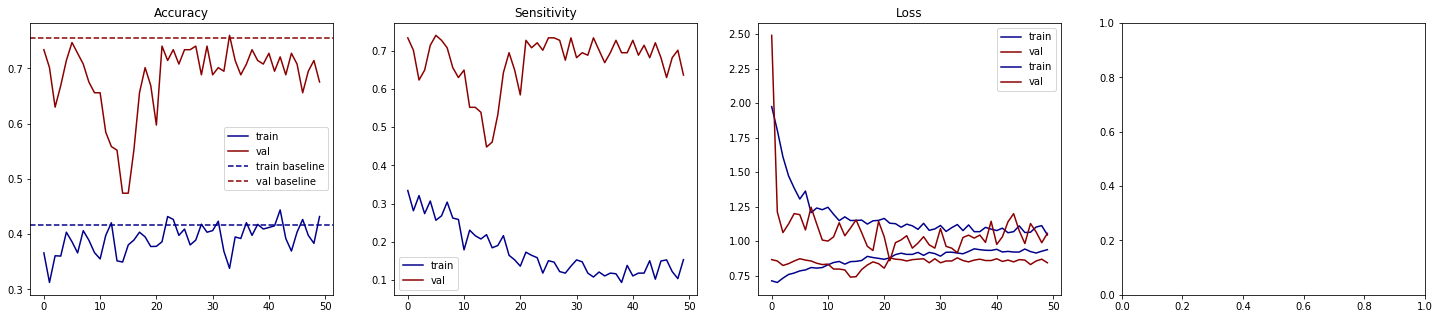

In [59]:
# plot performance
fig, ax = plt.subplots(1, 4, figsize=(25,5))

ax[0].plot(history.history['acc'], color='darkblue', label='train')
ax[0].plot(history.history['val_acc'], color='darkred', label='val')
ax[0].axhline(train_baseline_acc, color='darkblue', linestyle='dashed', label='train baseline')
ax[0].axhline(test_baseline_acc, color='darkred', linestyle='dashed', label='val baseline')
ax[0].legend()
ax[0].set_title('Accuracy')

ax[1].plot(history.history['sensitivity'], color='darkblue', label='train')
ax[1].plot(history.history['val_sensitivity'], color='darkred', label='val')
ax[1].legend()
ax[1].set_title('Sensitivity')

ax[2].plot(history.history['specificity'], color='darkblue', label='train')
ax[2].plot(history.history['val_specificity'], color='darkred', label='val')
ax[2].legend()
ax[2].set_title('Specificity')

ax[2].plot(history.history['loss'], color='darkblue', label='train')
ax[2].plot(history.history['val_loss'], color='darkred', label='val')
ax[2].legend()
ax[2].set_title('Loss');

In [45]:
# score training set and test set (even though it was used for validation)
train_preds = model.predict_generator(train_generator)
test_preds = model.predict_generator(test_generator)

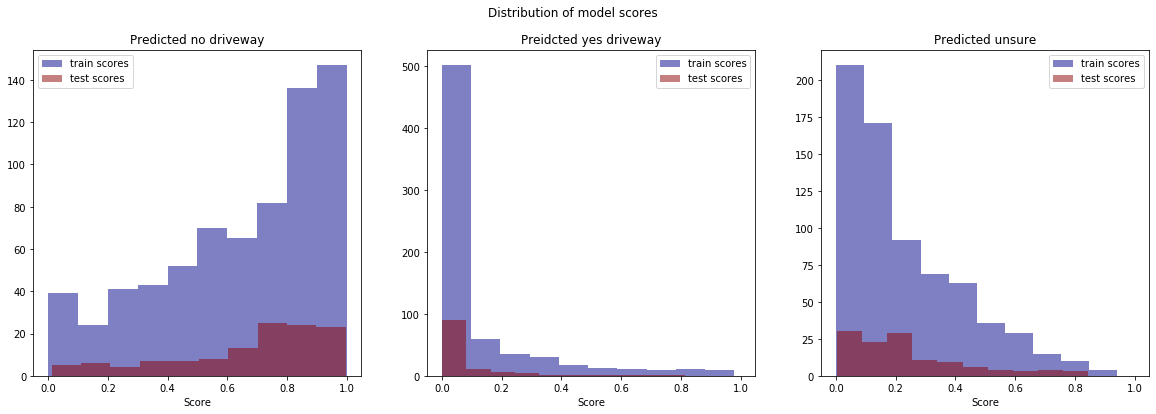

In [46]:
# binary prediction
if len(train_preds.shape) == 1:
    fig, ax = plt.subplots(1, 1, figsize=(20,10))

    ax.hist(train_preds, color='darkblue', alpha=0.5, label='train scores')
    ax.hist(test_preds, color='darkred', alpha=0.5, label='test scores')
    ax.legend()
    ax.set_xlabel('Score')
    ax.set_title('Distribution of model scores');
    
elif len(train_preds.shape) > 1:
    label_map = {0: 'Predicted no driveway', 1: 'Preidcted yes driveway', 2: 'Predicted unsure'}
    fig, ax = plt.subplots(1, train_preds.shape[1], sharex=True, figsize=(20,6))
    
    for i in range(train_preds.shape[1]):
        ax[i].hist(train_preds[:,i], color='darkblue', alpha=0.5, label='train scores')
        ax[i].hist(test_preds[:,i], color='darkred', alpha=0.5, label='test scores')
        ax[i].legend()
        ax[i].set_xlabel('Score')
        ax[i].set_title(label_map[i])
    fig.suptitle('Distribution of model scores');

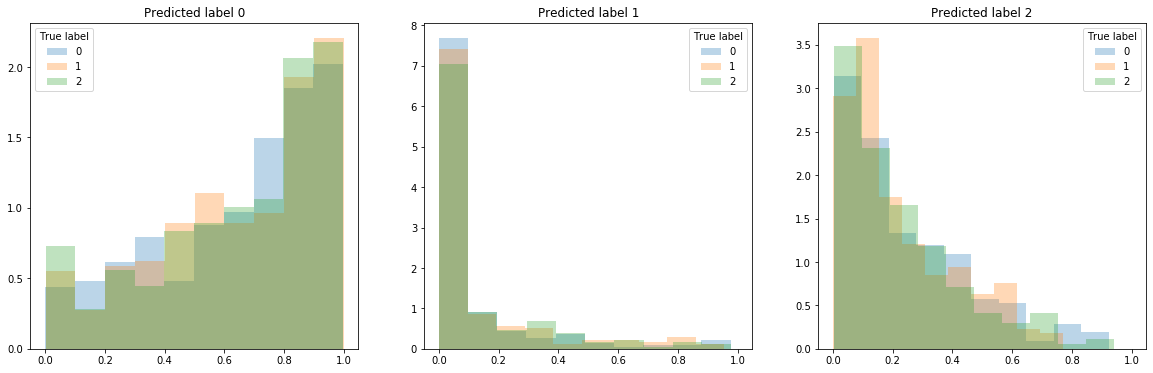

In [50]:
fig, ax = plt.subplots(1, 3, sharex=True, figsize=(20,6))
for i in range(train_preds.shape[1]):
    for lab in ['0', '1', '2']:
        ax[i].hist(train_preds[rebalanced_train[y_column]==lab,i], alpha=0.3, density=True, label=lab)
    ax[i].legend(title='True label');
    ax[i].set_title('Predicted label ' + str(i))

---